In [1]:
import openfermion
import openfermionpyscf
from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.transforms import jordan_wigner, bravyi_kitaev
from openfermion.transforms import get_fermion_operator
from openfermion.circuits import (uccsd_singlet_get_packed_amplitudes,
                               uccsd_singlet_generator, uccsd_generator,
                               uccsd_convert_amplitude_format)
import numpy as np
import cs_vqe as c
import itertools
import qubit_conversion as q_conv
from openfermion.linalg import LinearQubitOperator

In [2]:
import ast
import matplotlib
import matplotlib.pyplot as plt

f = open("hamiltonians.txt","r")
hamiltonians = ast.literal_eval(f.read())
f.close()

for h in hamiltonians.keys():
    print(h, '# qubits:', hamiltonians[h][1], 'A terms:', hamiltonians[h][5][3][1])

H2-S1_STO-3G_singlet # qubits: 18 A terms: ['IIZZZZZZZXIIIIIIII', 'IIIIIIIIIZIIIIIIII']
C1-O1_STO-3G_singlet # qubits: 16 A terms: ['IIZZZZZXIIIIIIII', 'IIIIIIIZIIIIIIII']
H1-Cl1_STO-3G_singlet # qubits: 16 A terms: ['IIZZZZZXIIIIIIII', 'IIIIIIIZIIIIIIII']
H1-Na1_STO-3G_singlet # qubits: 16 A terms: ['IIZZZZZZZXIIIIII', 'IIIIIIIIIZIIIIII']
H2-Mg1_STO-3G_singlet # qubits: 17 A terms: ['IIIZZIIZXZZIIZZZZ', 'IIIIIIIIZIIIIIIII']
H1-F1_3-21G_singlet # qubits: 18 A terms: ['IIIIZZZZZXZZIIIIII', 'IIZIIIIIZZIIIIIIII']
H1-Li1_3-21G_singlet # qubits: 18 A terms: ['IIIIZZZZIIZXIIIIII', 'IIZIIIIIIIZZIIIIII']
Be1_STO-3G_singlet # qubits: 5 A terms: ['IIIXI', 'IIIZI']
H1-F1_STO-3G_singlet # qubits: 8 A terms: ['IIXZZZZZ', 'IIZIIIII']
H1-Li1_STO-3G_singlet # qubits: 8 A terms: ['IIIIIXZZ', 'ZZIZIZIZ']
Ar1_STO-3G_singlet # qubits: 13 A terms: ['IIIZZZZZXZZZZ', 'IIIIIIIIZIIII']
F2_STO-3G_singlet # qubits: 15 A terms: ['IIIIIIIIIIIIZII', 'IIIIIIIIIIIXXYY']
H1-O1_STO-3G_singlet # qubits: 8 A terms: ['IIX

In [3]:
speciesname = 'H2-O1_STO-3G_singlet'

encoding = hamiltonians[speciesname][0] # in this dataset, always 'JW' for Jordan-Wigner, but leaves room for trying Bravyi-Kitaev as well
num_qubits = hamiltonians[speciesname][1] # number of qubits (all of these Hamiltonians have been tapered for molecular symmetries)
ham = hamiltonians[speciesname][2] # full Hamiltonian
ham_noncon = hamiltonians[speciesname][3] # noncontextual part of Hamiltonian, found by greedy DFS
true_gs = hamiltonians[speciesname][4] # ground state energy of full Hamiltonian (in Hartree)
gs_noncon = hamiltonians[speciesname][5] # list containing information about noncontextual ground state: zeroth entry is ground state energy of noncontextual part of Hamiltonian

print('number of qubits:', num_qubits)
print('true ground state energy:', true_gs)
print('noncontextual approximation to ground state energy:', gs_noncon[0])
#print(ham_noncon)

number of qubits: 10
true ground state energy: -83.92870248174707
noncontextual approximation to ground state energy: -83.87422390061549


In [4]:
model = c.quasi_model(ham_noncon)
fn_form = c.energy_function_form(ham_noncon, model)
gs_noncon = c.find_gs_noncon(ham_noncon)
gs_noncon_energy = gs_noncon[0]
ep_state = gs_noncon[1]
ham_context = {p:c for p,c in ham.items() if p not in ham_noncon}
print(c.csvqe_approximations_heuristic(ham, ham_noncon, num_qubits, true_gs))
#c.contextualQ_ham(ham_context)

[-83.92870248174707, [-83.8742239006154, -83.87753476380222, -83.89065311104855, -83.89785356785998, -83.91205889216378, -83.91813131301465, -83.92761703951228, -83.928628377509, -83.9286535410288, -83.92870248174643, -83.92870248174607], [0.054478581131661485, 0.051167717944849755, 0.03804937069851633, 0.030848913887083995, 0.016643589583281937, 0.010571168732411707, 0.0010854422347819082, 7.410423806675226e-05, 4.894071827266089e-05, 6.394884621840902e-13, 9.947598300641403e-13], [4, 0, 3, 2, 6, 5, 1, 7, 8, 9]]


In [5]:
print('commuting generators:',model[0], '\n')
print('anticommuting generators:',model[1], '\n')
print('Minimising configuration:', gs_noncon[1])
#print('term reconstruction:',model[2], '\n')

commuting generators: ['ZIIIIIIIII', 'IZIIIIIIII', 'IIZIIIIIII', 'IIIZIIIIII', 'IIIIZIIIII', 'IIIIIIZIII', 'IIIIIIIZII', 'IIIIIIIIZI', 'IIIIIIIIIZ'] 

anticommuting generators: ['IIIIZXZZZZ', 'IIIIIZIIII'] 

Minimising configuration: [[1, -1, -1, -1, -1, -1, -1, -1, -1], [9.576858245891391e-08, -0.9999999999999954]]


In [6]:
A = {p:ep_state[1][index] for index, p in enumerate(model[1])}
A

{'IIIIZXZZZZ': 9.576858245891391e-08, 'IIIIIZIIII': -0.9999999999999954}

In [7]:
def ontic_prob(ep_state, ontic_state):
    
    if ep_state[0] != ontic_state[0]:
        return 0
    
    else:
        prod = 1
        for index, r in enumerate(ep_state[1]):
            f = 1/2 * abs(r + ontic_state[1][index])
            prod *= f
        
        return prod    

def epistemic_dist(ep_state):
    size_G = len(ep_state[0])
    size_Ci = len(ep_state[1])
    size_R = size_G + size_Ci
    
    ep_prob = {}
    
    ontic_states = list(itertools.product([1, -1], repeat=size_R))
    
    for o in ontic_states:
        o_state = [list(o[0:size_G]), list(o[size_G:size_R])]
        o_prob = ontic_prob(ep_state, o_state)
        
        if o_prob != 0:
            ep_prob[o] = o_prob
    
    return ep_prob

In [8]:
epistemic_dist(ep_state)

{(1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1): 1.1379787092233828e-15,
 (1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1): 0.5000000478842901,
 (1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1): 1.137978491258188e-15,
 (1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1): 0.49999995211570764}

In [9]:
r1 = ep_state[1][0]
r2 = ep_state[1][1]
#t = np.arctan((r2 + 1) / r1)
r1, r2

(9.576858245891391e-08, -0.9999999999999954)

In [10]:
generators = model[0]

generators

['ZIIIIIIIII',
 'IZIIIIIIII',
 'IIZIIIIIII',
 'IIIZIIIIII',
 'IIIIZIIIII',
 'IIIIIIZIII',
 'IIIIIIIZII',
 'IIIIIIIIZI',
 'IIIIIIIIIZ']

In [78]:
import itertools
from itertools import chain, combinations
from copy import deepcopy
import math

def bin_to_int(bits):
    bit_string = deepcopy(bits)
    
    if type(bit_string) == str:
        bit_string = [int(b) for b in bit_string]
        
    for index, b in enumerate(bit_string):
        bit_string[index] = b * 2 ** (len(bit_string)-index-1)
    
    return sum(bit_string)


def int_to_bin(integer, num_qubits):
    if integer >= 2**num_qubits:
        raise ValueError('Input integer larger than specified number of bits')
    bin_str=bin(integer)[2:]
    leading_0 = ''.join(['0' for i in range(num_qubits-len(bin_str))])
    return leading_0 + bin_str


def add_eigenstate(r1, r2, index, num_qubits, theta=0, custom_amp=None):
    """
    """
    B = list(itertools.product([0,1], repeat=num_qubits))
    b1 = list(B[index])
    b2 = deepcopy(b1)
    b2[5] = (b2[5]+1)%2
    i1 = bin_to_int(b1)
    i2 = bin_to_int(b2)
    
    q0 = b1[9]
    q1 = b1[8]
    q2 = b1[7]
    q3 = b1[6]
    q4 = b1[5]
    q5 = b1[4] 

    parity=q0+q1+q2+q3+q5
    
    amp_ratio = (1 + r2 * (-1)**q4) / (r1 * (-1)**(parity))
    t = np.arctan(amp_ratio)
    psi = [0 for i in range(2**num_qubits)]
    
    if custom_amp is None:   
        psi[i1] = np.sin(t)*np.exp(1j*theta)
        psi[i2] = np.cos(t)*np.exp(1j*theta)
    else:
        psi[i1] = custom_amp[0]
        psi[i2] = custom_amp[1]
        
    return np.array(psi)


def expectation(op, state):
    state = np.array(state)
    conj_state = np.conjugate(state)
    O = LinearQubitOperator(op, num_qubits)
    
    O_state = O.matvec(state)
    expect = conj_state.dot(O_state)
    
    return expect


def discard_generator(ham_noncon, ham_context, generators):
    new_ham_noncon = deepcopy(ham_noncon)
    new_ham_context = deepcopy(ham_context)
    
    Z_indices = [g.index('Z') for g in generators]
    removed=[]
    
    for index in Z_indices:
        for p in ham_noncon:
            if p not in removed:
                if p[index] == 'Z':
                    new_ham_context[p] = ham_noncon[p]
                    del new_ham_noncon[p]
                    removed.append(p)
            
    return new_ham_noncon, new_ham_context


def rotate_operator(rotations, op):
    rot_op = {}
    
    for p in op.keys():
        p_ref = deepcopy(p)
        parity = 1
        coeff = op[p]
        for r in rotations:
            rotate_p = c.apply_rotation(r, p)
            p = list(rotate_p.keys())[0]
            parity *= rotate_p[p]
        
        rot_op[p] = parity * coeff
        
    return rot_op

def rotate_hamiltonian(rotations, ham, ham_noncon, ham_context):
    
    rot_ham={}
    rot_ham_noncon={}
    rot_ham_context={}

    for p in ham.keys():
        p_ref = deepcopy(p)
        parity = 1
        coeff = ham[p]
        for r in rotations:
            rotate_p = c.apply_rotation(r, p)
            p = list(rotate_p.keys())[0]
            parity *= rotate_p[p]
        
        rot_ham[p] = parity * coeff
        if p_ref in ham_noncon.keys():
            rot_ham_noncon[p] = parity * coeff
        else:
            rot_ham_context[p] = parity * coeff
            
    return rot_ham, rot_ham_noncon, rot_ham_context


def rotate_state(rotations, state):
    
    rot_state = deepcopy(state)
    
    for r in rotations:
        r_op = QubitOperator('', 1/np.sqrt(2)) - q_conv.dict_to_QubitOperator({r[1]: 1/np.sqrt(2)*1j}, num_qubits)
        r_op = LinearQubitOperator(r_op, num_qubits)
        rot_state = r_op.matvec(rot_state)
        
    return rot_state


def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


def find_eigenstate_indices(initial, removed_Z_indices):
    bins = []
    index_powerset = list(powerset(removed_Z_indices))
    
    for comb in index_powerset:
        initial_ref = list(deepcopy(initial))
        for c in comb:
            initial_ref[c] = str((int(initial_ref[c])+1)%2)
        bins.append(bin_to_int(''.join(initial_ref)))
    
    return bins


def random_vector(n):
    components = [np.random.normal() for i in range(n)]
    r = math.sqrt(sum(x*x for x in components))
    v = [x/r for x in components]
    return v


def random_complex_unit():
        rand_vec = random_vector(2)
        x = rand_vec[0]
        y = rand_vec[1]
        
        return x + y*1j
    
def expectation_optimiser(ham_n, ham_c, amps, initial_state, Z_indices, num_qubits, rotations=None):
    eigenstate_indices = find_eigenstate_indices(initial_state, Z_indices)
    
    psi = np.array([0 for i in range(2**num_qubits)], dtype=complex)
    for index, i in enumerate(eigenstate_indices):
        psi += (amps[index])*add_eigenstate(r1=r1, r2=r2, theta=0, index=i, num_qubits=num_qubits)
    
    if rotations is not None:
        psi = rotate_state(rotations, psi)
    
    expect_noncon = expectation(ham_n, psi)
    expect_context = expectation(ham_c, psi)
    
    return expect_noncon, expect_context

In [12]:
generators

['ZIIIIIIIII',
 'IZIIIIIIII',
 'IIZIIIIIII',
 'IIIZIIIIII',
 'IIIIZIIIII',
 'IIIIIIZIII',
 'IIIIIIIZII',
 'IIIIIIIIZI',
 'IIIIIIIIIZ']

['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIZIIIII', 'IIIZIIIIII', 'IIZIIIIIII', 'IZIIIIIIII', 'ZIIIIIIIII'] [9, 8, 7, 6, 4, 3, 2, 1, 0]


TypeError: add_eigenstate() got an unexpected keyword argument 'n'

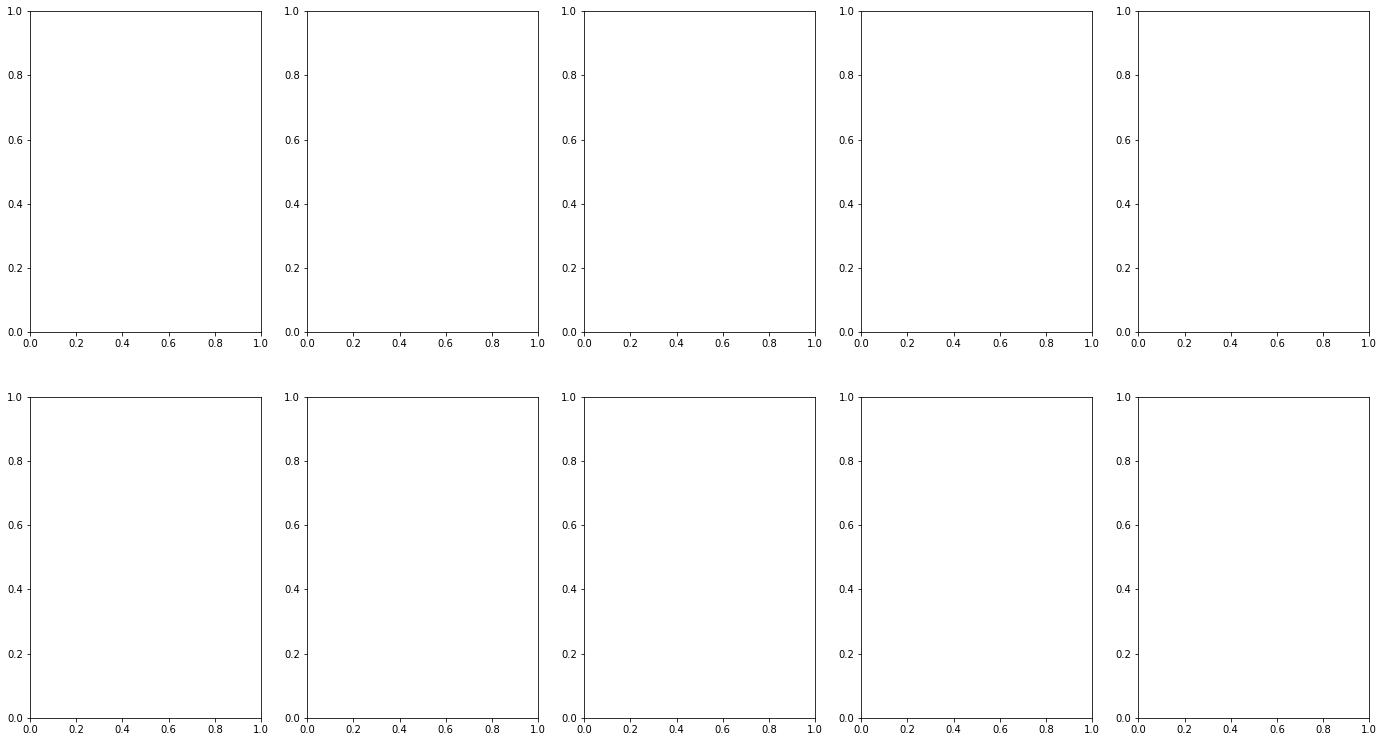

In [77]:
#take expectation value algebraically
from matplotlib import pyplot as plt
shots=50
initial_state = '0111101111'

#rot_ham, rot_ham_noncon, rot_ham_context = rotate_hamiltonian(rotations, ham, ham_noncon, ham_context)

def expectation_optimiser(ham_n, ham_c, p, Z_indices, initial_state):
    eigenstate_indices = find_eigenstate_indices(initial_state, Z_indices)
    
    psi = np.array([0 for i in range(2**num_qubits)], dtype=complex)
    for index, i in enumerate(eigenstate_indices):
        psi += (p[index])*add_eigenstate(r1=r1, r2=r2, theta=0, index=i, num_qubits=num_qubits)
    
    expect_noncon = expectation(ham_n, psi)
    expect_context = expectation(ham_c, psi)
    
    return expect_noncon, expect_context

fig, axs = plt.subplots(nrows = 2, ncols = 5, figsize = (24,13))
grid_pos = [(0,0),(0,1),(0,2),(0,3),(0,4),(1,0),(1,1),(1,2),(1,3),(1,4)]
grid_pos.reverse()

X=list(range(1, shots+1))

for index, grid in enumerate(grid_pos):
    
    removed_index = list(range(index, 9))
    removed_index.reverse()
    removed_generators = [generators[i] for i in removed_index]
    Z_indices = [g.find('Z') for g in removed_generators]
    print(removed_generators, Z_indices)
    
    new_ham_noncon, new_ham_context = discard_generator(ham_noncon, ham_context, removed_generators)

    #rot_ham_q = q_conv.dict_to_QubitOperator(ham, num_qubits)
    new_ham_noncon_q = q_conv.dict_to_QubitOperator(new_ham_noncon, num_qubits)
    new_ham_context_q = q_conv.dict_to_QubitOperator(new_ham_context, num_qubits)

    eigenstate_indices = sorted(find_eigenstate_indices(initial_state, Z_indices))
    
    random_amplitudes=[]
    for i in range(shots):  
        rand_vec = random_vector(len(eigenstate_indices))
        rand_vec = sorted([random_complex_unit()*c for c in rand_vec], key=abs)
        rand_vec.reverse()
        random_amplitudes.append(rand_vec)

    #amps=[random_vector(len(eigenstate_indices)) for i in range(shots)]
    Y_noncon=[]
    Y_context=[]
    Y_combined=[]
    Y_full=[]

    #A_op = QubitOperator('Y0 Z1 Z2 Z3 Z4 Z5 Y6 Z7', r1) + QubitOperator('Z6', r2)
    #A = LinearQubitOperator(A_op, num_qubits)

    for amps in random_amplitudes:
        expect_noncon, expect_context = expectation_optimiser(new_ham_noncon_q, new_ham_context_q, amps, Z_indices, initial_state)

        #Y_full.append(expect_full)
        Y_noncon.append(expect_noncon)
        Y_context.append(expect_context)
        Y_combined.append(expect_noncon+expect_context)

        #print(p, expect_noncon + expect_context < gs_noncon_energy)
        #print((np.conjugate(psi)).dot(psi))
        #Verify +1-eigenstate
        #A_psi = A.matvec(psi)
        #print(psi_conj.dot(A_psi))
    
    axs[grid].plot(X, Y_noncon, color='orange')
    #axs[grid].scatter(X, Y_context, color='blue', marker = 'x')
    #axs[grid].plot(X, Y_context, color='blue', ls='--')
    axs[grid].scatter(X, Y_combined, color='black', marker = 'x')
    axs[grid].plot(X, Y_combined, color='black', ls='--')
    #plt.plot(range(shots), Y_combined, color='purple')
    axs[grid].hlines(gs_noncon_energy, 1, shots, color='r')
    axs[grid].hlines(true_gs, 1, shots, color='g')
    
    axs[grid].set_xticks(X)
    axs[grid].set_title("%i generators removed" % abs(index-9))
    if grid[0] == 1:
        axs[grid].set_xlabel('Sample Number',fontsize=16)
    if grid[1] == 0:
        axs[grid].set_ylabel('Energy (Ha)',fontsize=18)
    #print('<H> w.r.t. simultaneous eigenstate:', expect)
    #print('Noncontextual approximation:', gs_noncon_energy)
    #print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match? 

In [ ]:
fig.savefig("H2O-generator-removal-energies-ordered-random-amplitudes.png", dpi=300)

In [75]:
from openfermion.linalg import LinearQubitOperator

ham_q = q_conv.dict_to_QubitOperator(ham, num_qubits)
ham_noncon_q = q_conv.dict_to_QubitOperator(ham_noncon, num_qubits)
ham_context_q = q_conv.dict_to_QubitOperator(ham_context, num_qubits)

#take expectation value algebraically

for p in np.linspace(0, 1, 1):
    psi = add_eigenstate(r1=r1, r2=r2, index=495, theta=0, n=0, num_qubits=num_qubits)
    expect = expectation(ham_q, psi)
    
    print('<H> w.r.t. simultaneous eigenstate:', expect)
    print('Noncontextual approximation:', gs_noncon_energy)
    print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match?

TypeError: add_eigenstate() got an unexpected keyword argument 'n'

In [54]:
sorted(find_eigenstate_indices(initial_state, [0,4]))

[463, 495, 975, 1007]

In [115]:
#take expectation value algebraically
from matplotlib import pyplot as plt
shots=30
initial_state = '0111101111'

removed_index = [0, 4]#[0, 3, 4]
removed_generators = [generators[i] for i in removed_index]
Z_indices = [g.find('Z') for g in removed_generators]
print(removed_generators, Z_indices)


new_ham_noncon, new_ham_context = discard_generator(ham_noncon, ham_context, removed_generators)
new_ham_noncon_q = q_conv.dict_to_QubitOperator(new_ham_noncon, num_qubits)
new_ham_context_q = q_conv.dict_to_QubitOperator(new_ham_context, num_qubits)

eigenstate_indices = find_eigenstate_indices(initial_state, Z_indices)
print(eigenstate_indices)

prob=0.99999
amps=[]
for i in range(shots):
    amp_1 = [np.sqrt(prob)]
    amp_rest = [np.sqrt(1-prob)*a for a in random_vector(len(eigenstate_indices)-1)]
    amp_1 += amp_rest
    amps.append(amp_1)

X=list(range(1, shots+1))
Y_noncon=[]
Y_context=[]
Y_combined=[]
Y_full=[]

#A_op = QubitOperator('Y0 Z1 Z2 Z3 Z4 Z5 Y6 Z7', r1) + QubitOperator('Z6', r2)
#A = LinearQubitOperator(A_op, num_qubits)

for p in amps:
    expect_noncon, expect_context = expectation_optimiser(ham_n=new_ham_noncon_q, ham_c=new_ham_context_q, amps=p,
                                                          initial_state=initial_state,num_qubits=num_qubits,Z_indices=Z_indices)
    total = expect_noncon + expect_context
    #Y_full.append(expect_full)
    Y_noncon.append(expect_noncon)
    Y_context.append(expect_context)
    Y_combined.append(total)
    print(total, total < gs_noncon_energy, p)

#plt.plot(X, Y_noncon, color='orange')
#plt.scatter(X, Y_context, color='blue', marker = 'x')
#plt.plot(X, Y_context, color='blue', ls='--')
plt.scatter(X, Y_combined, color='black', marker = 'x')
plt.plot(X, Y_combined, color='black', ls='--')
plt.hlines(gs_noncon_energy, 1, shots, color='r')
plt.hlines(true_gs, 1, shots, color='g')
#plt.hlines(true_gs, 1, shots, color='g')

['ZIIIIIIIII', 'IIIIZIIIII'] [0, 4]
[495, 1007, 463, 975]
(-83.87419692856855+0j) False [0.9999949999875, 0.0016346754466762448, -0.0018547519190871698, 0.0019717331215534134]
(-83.87416958116845+0j) False [0.9999949999875, 0.0030359385708147455, 0.00040054669125097047, -0.000789074991570323]
(-83.87419865453302+0j) False [0.9999949999875, 0.0018387245486034944, -0.0002647073601789115, -0.0025591057125067106]


KeyboardInterrupt: 

In [86]:
gs_noncon_energy

-83.87422390061549

In [93]:
new_ham_noncon, new_ham_context = discard_generator(ham_noncon, ham_context, ['IIIZIIIIII', 'ZIIIIIIIII'])

q_corr_terms = []

for t in list(new_ham_context.keys()):
    commutes = []
    for g in generators:
        if c.commute(t, g):
            commutes.append(g)
    #print(t, 'commutes with the noncontextual generators:', commutes)
    if commutes == generators:
        q_corr_terms.append(t)
        
if q_corr_terms == []:
    print('No quantum correction')
else:
    print('Terms admitting quantum correction:', q_corr_terms)

Terms admitting quantum correction: ['IIIZIIIIII', 'ZZIZZIIZIZ', 'IZIZIIIIII', 'ZIIZZIIZIZ', 'IIIZIIIIZI', 'IIIZIIIIIZ', 'ZZIZZIIZZZ', 'ZZIZZIIZII', 'IIZZIIIIII', 'IIIZIIZIII', 'ZZIZZIZZIZ', 'ZIIZIIIIII', 'IIZZIIZZZZ', 'IIIZZIIIII', 'ZZIZIIIZIZ', 'IZIZZIIZIZ', 'ZZZZZIIZIZ', 'ZZZZZIZIZI', 'IIIZIIIZII', 'IIIZIZIIII', 'ZIIZZZIIII', 'ZZIZZIIIIZ', 'ZZIZZZIZIZ', 'IZIZIZIZIZ', 'IIIZZXZZZZ', 'ZIIZIXZZZZ', 'IZIZZXZIZI', 'ZZIZIXZIZI', 'ZIIIIIIIII', 'ZIIIZZIIII', 'ZZZIZIZIZI', 'ZIIIIXZZZZ', 'ZZIIIIIIII', 'ZZIIZZIIII', 'ZIIIIZIIII', 'ZIZIZIZIZI', 'ZIIIZIIIII', 'ZIIIIIIIIZ', 'ZIIIZZIIZI', 'ZIIIIIIIZI', 'ZIIIZZIIIZ', 'ZZZIZIZIZZ', 'ZZZIZIZIII', 'ZIIIIIIZII', 'ZIIIZZZIII', 'ZZZIZIZZZI', 'ZIZIZZIIII', 'ZZZIZZZIZI', 'ZIIIIIZIII', 'ZIIIZZIZII', 'ZIZIIIIIII', 'ZZZIZIIIZI', 'ZZZIIIZIZI', 'ZZIIZIIZIZ', 'ZZIIZIZIZI', 'ZIIIIXZZIZ', 'ZZIIIXZZZZ', 'ZIIIIXZZZI', 'ZIZIIXZZZZ', 'ZIIIIXIZZZ', 'ZIIIIXZIZZ', 'ZZZIIXIZIZ', 'ZIIIZXZZZZ']


In [32]:
B = list(itertools.product([0,1], repeat=num_qubits))
for index in range(2**(num_qubits)):
    b1 = list(B[index])
    b2 = deepcopy(b1)
    b2[5] = (b2[5]+1)%2
    i1 = bin_to_int(b1)
    i2 = bin_to_int(b2)
    print(i1, i2)

0 16
1 17
2 18
3 19
4 20
5 21
6 22
7 23
8 24
9 25
10 26
11 27
12 28
13 29
14 30
15 31
16 0
17 1
18 2
19 3
20 4
21 5
22 6
23 7
24 8
25 9
26 10
27 11
28 12
29 13
30 14
31 15
32 48
33 49
34 50
35 51
36 52
37 53
38 54
39 55
40 56
41 57
42 58
43 59
44 60
45 61
46 62
47 63
48 32
49 33
50 34
51 35
52 36
53 37
54 38
55 39
56 40
57 41
58 42
59 43
60 44
61 45
62 46
63 47
64 80
65 81
66 82
67 83
68 84
69 85
70 86
71 87
72 88
73 89
74 90
75 91
76 92
77 93
78 94
79 95
80 64
81 65
82 66
83 67
84 68
85 69
86 70
87 71
88 72
89 73
90 74
91 75
92 76
93 77
94 78
95 79
96 112
97 113
98 114
99 115
100 116
101 117
102 118
103 119
104 120
105 121
106 122
107 123
108 124
109 125
110 126
111 127
112 96
113 97
114 98
115 99
116 100
117 101
118 102
119 103
120 104
121 105
122 106
123 107
124 108
125 109
126 110
127 111
128 144
129 145
130 146
131 147
132 148
133 149
134 150
135 151
136 152
137 153
138 154
139 155
140 156
141 157
142 158
143 159
144 128
145 129
146 130
147 131
148 132
149 133
150 134
151 135
152 

-83.92870248174658
('511', -0.013482770090502976)


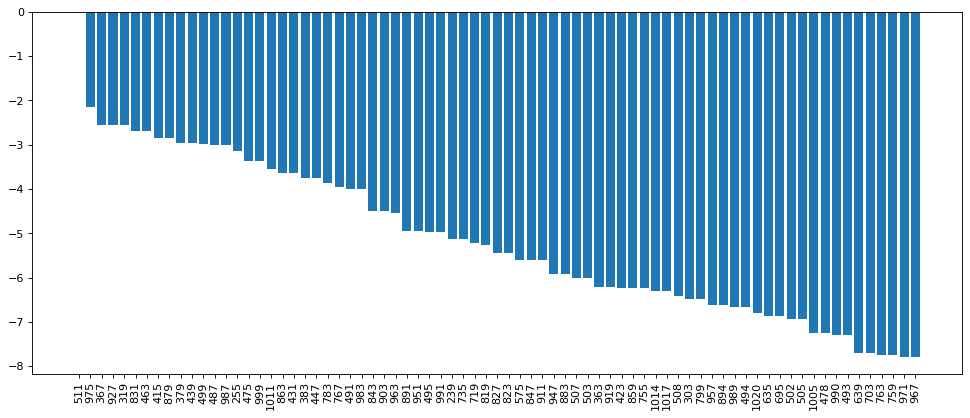

In [99]:
from openfermion.linalg import get_sparse_operator, get_ground_state

gs = get_ground_state(get_sparse_operator(ham_q, num_qubits).toarray())
print(gs[0])

amp_list = [abs(a)**2 for a in list(gs[1])]
sig_amp_list = sorted([(str(index), np.log10(a)) for index, a in enumerate(amp_list) if a > 0.00000001], key=lambda x:x[1])
sig_amp_list.reverse()
print(sig_amp_list[0])
XY = list(zip(*sig_amp_list))
X = XY[0]
Y = XY[1]

from matplotlib.pyplot import figure

figure(figsize=(15, 6), dpi=80)

plt.bar(X, Y)
plt.xticks(rotation=90)
plt.show()

In [19]:
import openfermion
import openfermionpyscf
from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.transforms import jordan_wigner, bravyi_kitaev
from openfermion.transforms import get_fermion_operator
from openfermion.circuits import (uccsd_singlet_get_packed_amplitudes,
                               uccsd_singlet_generator, uccsd_generator,
                               uccsd_convert_amplitude_format)
import numpy as np
import cs_vqe as c
import itertools
import qubit_conversion as q_conv

singlet_bool = True # Set general UCCSD or singlet UCCSD.

bond_len =1#0.96
atom_1 = 'O'
atom_2 = 'H'
atom_3 = 'H'
basis = 'sto3g'
multiplicity = 1
charge = 0

coordinate_1 = (0.0, 0.0, 0.0)
coordinate_2 = (0.0, 0.0, bond_len)
coordinate_3 = (0.0, bond_len, 0.0)
geometry = [(atom_1, coordinate_1), (atom_2, coordinate_2), (atom_3, coordinate_3)]

molecule_data = MolecularData(geometry, basis, multiplicity, charge, description='Test')
#molecule.load()

# Set calculation parameters.
run_scf = 1
run_mp2 = 1
run_cisd = 0
run_ccsd = 0
run_fci = 1
delete_input = True
delete_output = True

# Run pyscf.
molecule = run_pyscf(molecule_data,
                     run_scf=run_scf,
                     run_mp2=run_mp2,
                     run_cisd=run_cisd,
                     run_ccsd=run_ccsd,
                     run_fci=run_fci)

#molecule.load()
#print(molecule)

ham_2 = get_fermion_operator(molecule.get_molecular_hamiltonian())
ham_2_q = jordan_wigner(ham_2)
print('Hamiltonian:', '\n', ham_2_q, '\n')

scf = True      # Hartree-Fock.
mp2 = True      # Moller-Plesset 2.
cisd = True     # Configuration interaction singles and doubles.
ccsd = True     # Coupled cluster singles and doubles.
fci = True      # Full configuration interaction.

calculated_molecule = run_pyscf(molecule_data, scf, mp2, cisd, ccsd, fci)

if ccsd:
    ccsd_single_amps = calculated_molecule.ccsd_single_amps
    ccsd_double_amps = calculated_molecule.ccsd_double_amps

num_electrons = calculated_molecule.n_electrons
num_qubits = 2*calculated_molecule.n_orbitals

if singlet_bool:
    # Get singlet UCCSD generator.
    packed_amps = uccsd_singlet_get_packed_amplitudes(ccsd_single_amps,  ccsd_double_amps, num_qubits, num_electrons)
    ucc_sing = uccsd_singlet_generator(packed_amps, num_qubits, num_electrons)
    #print(ucc_sing)

else:
    # Get general UCCSD operator.
    ucc_op = uccsd_generator(ccsd_single_amps, ccsd_double_amps)
    #print(ucc_op)
    
ucc_q = jordan_wigner(ucc_sing)
print('UCCSD ansatz:', '\n', ucc_q)

Hamiltonian: 
 (-46.42419658498402+0j) [] +
(-0.014397227557119406+0j) [X0 X1 Y2 Y3] +
(-0.006109723634552669+0j) [X0 X1 Y2 Z3 Z4 Z5 Z6 Y7] +
(-0.00859537847616171+0j) [X0 X1 Y2 Z3 Z4 Z5 Z6 Z7 Z8 Z9 Z10 Y11] +
(-0.006109723634552669+0j) [X0 X1 X3 Z4 Z5 X6] +
(-0.00859537847616171+0j) [X0 X1 X3 Z4 Z5 Z6 Z7 Z8 Z9 X10] +
(-0.0029362378838068237+0j) [X0 X1 Y4 Y5] +
(-0.0037847449694258244+0j) [X0 X1 Y4 Z5 Z6 Z7 Z8 Z9 Z10 Z11 Z12 Y13] +
(-0.0037847449694258244+0j) [X0 X1 X5 Z6 Z7 Z8 Z9 Z10 Z11 X12] +
(-0.007033925395803082+0j) [X0 X1 Y6 Y7] +
(-0.00012009372166311847+0j) [X0 X1 Y6 Z7 Z8 Z9 Z10 Y11] +
(-0.00012009372166311847+0j) [X0 X1 X7 Z8 Z9 X10] +
(-0.006508243246763192+0j) [X0 X1 Y8 Y9] +
(-0.00794432639621333+0j) [X0 X1 Y10 Y11] +
(-0.0048910522196745215+0j) [X0 X1 Y12 Y13] +
(0.014397227557119406+0j) [X0 Y1 Y2 X3] +
(0.006109723634552669+0j) [X0 Y1 Y2 Z3 Z4 Z5 Z6 X7] +
(0.00859537847616171+0j) [X0 Y1 Y2 Z3 Z4 Z5 Z6 Z7 Z8 Z9 Z10 X11] +
(-0.006109723634552669+0j) [X0 Y1 Y3 Z4 Z5 X6] +


UCCSD ansatz: 
 8.260587265541962e-05j [X0 X1 X10 Y11] +
8.260587265541962e-05j [X0 X1 Y10 X11] +
4.771996305940251e-05j [X0 X1 X12 Y13] +
4.771996305940251e-05j [X0 X1 Y12 X13] +
-8.260587265541962e-05j [X0 Y1 X10 X11] +
8.260587265541962e-05j [X0 Y1 Y10 Y11] +
-4.771996305940251e-05j [X0 Y1 X12 X13] +
4.771996305940251e-05j [X0 Y1 Y12 Y13] +
6.45041454581078e-05j [X0 Z1 Z2 Z3 X4 X10 Z11 Y12] +
6.45041454581078e-05j [X0 Z1 Z2 Z3 X4 Y10 Z11 X12] +
-6.45041454581078e-05j [X0 Z1 Z2 Z3 Y4 X10 Z11 X12] +
6.45041454581078e-05j [X0 Z1 Z2 Z3 Y4 Y10 Z11 Y12] +
3.22520727290539e-05j [X0 Z1 Z2 Z3 Z4 X5 X10 Z11 Z12 Y13] +
3.22520727290539e-05j [X0 Z1 Z2 Z3 Z4 X5 Y10 Z11 Z12 X13] +
3.22520727290539e-05j [X0 Z1 Z2 Z3 Z4 X5 X11 Y12] +
3.22520727290539e-05j [X0 Z1 Z2 Z3 Z4 X5 Y11 X12] +
-3.22520727290539e-05j [X0 Z1 Z2 Z3 Z4 Y5 X10 Z11 Z12 X13] +
3.22520727290539e-05j [X0 Z1 Z2 Z3 Z4 Y5 Y10 Z11 Z12 Y13] +
-3.22520727290539e-05j [X0 Z1 Z2 Z3 Z4 Y5 X11 X12] +
3.22520727290539e-05j [X0 Z1 Z2 Z3 Z4 Y5 Y1

In [23]:
from qiskit.aqua.algorithms import NumPyEigensolver

ham_2 = q_conv.QubitOperator_to_dict(ham_2_q, 14)
result = NumPyEigensolver(q_conv.dict_to_WeightedPauliOperator(ham_2)).run()
true_gs = np.real(result.eigenvalues)

In [24]:
true_gs

array([-75.01086514])

In [28]:
len(list(ham.keys())), len(['IIIIIIIIII', 'ZIIIIIIIII', 'YZYIIIIIII', 'XZXIIIIIII', 'YZZZZZYIII', 'XZZZZZXIII', 'YZZZZZZZZZ', 'XZZZZZZZZZ', 'IZIIIIIIII', 'IYZYIIIIII', 'IXZXIIIIII', 'IYZZZZZYII', 'IXZZZZZXII', 'IYZZZZZZZZ', 'IXZZZZZZZZ', 'IIZIIIIIII', 'IIYZZZYIII', 'IIXZZZXIII', 'IIYZZZZZZZ', 'IIXZZZZZZZ', 'IIIZIIIIII', 'IIIYZZZYII', 'IIIXZZZXII', 'IIIYZZZZZZ', 'IIIXZZZZZZ', 'IIIIZIIIII', 'IIIIYZZZZZ', 'IIIIXZZZZZ', 'IIIIIZIIII', 'IIIIIYZZZZ', 'IIIIIXZZZZ', 'IIIIIIZIII', 'IIIIIIYZZZ', 'IIIIIIXZZZ', 'IIIIIIIZII', 'IIIIIIIYZZ', 'IIIIIIIXZZ', 'IIIIIIIIZI', 'IIIIIIIIIZ', 'ZZIIIIIIII', 'YIYIIIIIII', 'XIXIIIIIII', 'YIZZZZYIII', 'XIZZZZXIII', 'YIZZZZZZZZ', 'XIZZZZZZZZ', 'ZYZYIIIIII', 'ZXZXIIIIII', 'YXXYIIIIII', 'YYXXIIIIII', 'XXYYIIIIII', 'XYYXIIIIII', 'YXIXZZYIII', 'YYIYZZYIII', 'XXIXZZXIII', 'XYIYZZXIII', 'YXIXZZZZZZ', 'YYIYZZZZZZ', 'XXIXZZZZZZ', 'XYIYZZZZZZ', 'YXIIXYIIII', 'YYIIXXIIII', 'XXIIYYIIII', 'XYIIYXIIII', 'YXIIIXZZZZ', 'YYIIIYZZZZ', 'XXIIIXZZZZ', 'XYIIIYZZZZ', 'ZYZZZZZYII', 'ZXZZZZZXII', 'YXXZZZZYII', 'YYXZZZZXII', 'XXYZZZZYII', 'XYYZZZZXII', 'YXIIIIXYII', 'YYIIIIXXII', 'XXIIIIYYII', 'XYIIIIYXII', 'YXIIIIIXZZ', 'YYIIIIIYZZ', 'XXIIIIIXZZ', 'XYIIIIIYZZ', 'YXIIIIIIXY', 'YYIIIIIIXX', 'XXIIIIIIYY', 'XYIIIIIIYX', 'ZYZZZZZZZZ', 'ZXZZZZZZZZ', 'YXXZZZZZZZ', 'YYXZZZZZZZ', 'XXYZZZZZZZ', 'XYYZZZZZZZ', 'YXIIIIXZZZ', 'YYIIIIXZZZ', 'XXIIIIYZZZ', 'XYIIIIYZZZ', 'YXIIIIIIII', 'YYIIIIIIII', 'XXIIIIIIII', 'XYIIIIIIII', 'YXIIXZZZZZ', 'YYIIXZZZZZ', 'XXIIYZZZZZ', 'XYIIYZZZZZ', 'ZIZIIIIIII', 'ZIYZZZYIII', 'ZIXZZZXIII', 'ZIYZZZZZZZ', 'ZIXZZZZZZZ', 'YZIZZZYIII', 'XZIZZZXIII', 'YZIZZZZZZZ', 'XZIZZZZZZZ', 'YZXIXZZZZZ', 'YZYIYZZZZZ', 'YZYIXZZZZZ', 'XZXIYZZZZZ', 'XZXIXZZZZZ', 'XZYIYZZZZZ', 'YZXIIIXZZZ', 'YZYIIIYZZZ', 'YZYIIIXZZZ', 'XZXIIIYZZZ', 'XZXIIIXZZZ', 'XZYIIIYZZZ', 'ZIIZIIIIII', 'YZYZIIIIII', 'XZXZIIIIII', 'YZZIZZYIII', 'XZZIZZXIII', 'YZZIZZZZZZ', 'XZZIZZZZZZ', 'YZZXXYIIII', 'YZZYXXIIII', 'XZZXYYIIII', 'XZZYYXIIII', 'YZZXIXZZZZ', 'YZZYIYZZZZ', 'XZZXIXZZZZ', 'XZZYIYZZZZ', 'ZIIYZZZYII', 'ZIIXZZZXII', 'YZYYZZZYII', 'YZYXZZZXII', 'XZXYZZZYII', 'XZXXZZZXII', 'YZZXIIXYII', 'YZZYIIXXII', 'XZZXIIYYII', 'XZZYIIYXII', 'YZZXIIIXZZ', 'YZZYIIIYZZ', 'XZZXIIIXZZ', 'XZZYIIIYZZ', 'YZZXIIIIXY', 'YZZYIIIIXX', 'XZZXIIIIYY', 'XZZYIIIIYX', 'ZIIYZZZZZZ', 'ZIIXZZZZZZ', 'YZYYZZZZZZ', 'YZYXZZZZZZ', 'XZXYZZZZZZ', 'XZXXZZZZZZ', 'YZZXIIXZZZ', 'YZZYIIXZZZ', 'XZZXIIYZZZ', 'XZZYIIYZZZ', 'YZZXIIIIII', 'YZZYIIIIII', 'XZZXIIIIII', 'XZZYIIIIII', 'YZZXXZZZZZ', 'YZZYXZZZZZ', 'XZZXYZZZZZ', 'XZZYYZZZZZ', 'ZIIIZIIIII', 'ZIIIYZZZZZ', 'ZIIIXZZZZZ', 'YZYIZIIIII', 'XZXIZIIIII', 'YZZZIZYIII', 'XZZZIZXIII', 'YZZZIZZZZZ', 'XZZZIZZZZZ', 'YZZZXIXZZZ', 'YZZZYIYZZZ', 'YZZZYIXZZZ', 'XZZZXIYZZZ', 'XZZZXIXZZZ', 'XZZZYIYZZZ', 'YZZZXIIIII', 'YZZZYIIIII', 'XZZZXIIIII', 'XZZZYIIIII', 'ZIIIIZIIII', 'YZYIIZIIII', 'XZXIIZIIII', 'YZZZZIYIII', 'XZZZZIXIII', 'YZZZZIZZZZ', 'XZZZZIZZZZ', 'YZZZYYZYII', 'YZZZYXZXII', 'XZZZXYZYII', 'XZZZXXZXII', 'YZZZZXIXZZ', 'YZZZZYIYZZ', 'XZZZZXIXZZ', 'XZZZZYIYZZ', 'YZZZYYZZZZ', 'YZZZYXZZZZ', 'XZZZXYZZZZ', 'XZZZXXZZZZ', 'YZZZZXIIII', 'YZZZZYIIII', 'XZZZZXIIII', 'XZZZZYIIII', 'ZIIIIYZZZZ', 'ZIIIIXZZZZ', 'YZYIIYZZZZ', 'YZYIIXZZZZ', 'XZXIIYZZZZ', 'XZXIIXZZZZ', 'YZZZZXXZZZ', 'YZZZZYXZZZ', 'XZZZZXYZZZ', 'XZZZZYYZZZ', 'ZIIIIIZIII', 'ZIIIIIYZZZ', 'ZIIIIIXZZZ', 'YZYIIIZIII', 'XZXIIIZIII', 'YZZZZZIZZZ', 'XZZZZZIZZZ', 'ZIIIIIIZII', 'YZYIIIIZII', 'XZXIIIIZII', 'YZZZZZYZII', 'XZZZZZXZII', 'YZZZZZZIZZ', 'XZZZZZZIZZ', 'YZZZZZZXXY', 'YZZZZZZYXX', 'XZZZZZZXYY', 'XZZZZZZYYX', 'ZIIIIIIYZZ', 'ZIIIIIIXZZ', 'YZYIIIIYZZ', 'YZYIIIIXZZ', 'XZXIIIIYZZ', 'XZXIIIIXZZ', 'YZZZZZYYZZ', 'YZZZZZYXZZ', 'XZZZZZXYZZ', 'XZZZZZXXZZ', 'YZZZZZZXII', 'YZZZZZZYII', 'XZZZZZZXII', 'XZZZZZZYII', 'YZZZYIIYZZ', 'YZZZYIIXZZ', 'XZZZXIIYZZ', 'XZZZXIIXZZ', 'ZIIIIIIIZI', 'YZYIIIIIZI', 'XZXIIIIIZI', 'YZZZZZYIZI', 'XZZZZZXIZI', 'YZZZZZZZIZ', 'XZZZZZZZIZ', 'ZIIIIIIIIZ', 'YZYIIIIIIZ', 'XZXIIIIIIZ', 'YZZZZZYIIZ', 'XZZZZZXIIZ', 'YZZZZZZZZI', 'XZZZZZZZZI', 'YZZZZZZZYY', 'YZZZZZZZYX', 'XZZZZZZZXY', 'XZZZZZZZXX', 'IZZIIIIIII', 'IYIYIIIIII', 'IXIXIIIIII', 'IYIZZZZYII', 'IXIZZZZXII', 'IYIZZZZZZZ', 'IXIZZZZZZZ', 'IYXIXYIIII', 'IYYIYYIIII', 'IXXIXXIIII', 'IXYIYXIIII', 'IYXIXZZZZZ', 'IYYIYZZZZZ', 'IXXIXZZZZZ', 'IXYIYZZZZZ', 'IZYZZZYIII', 'IZXZZZXIII', 'IYXXZZYIII', 'IYYXZZXIII', 'IXXYZZYIII', 'IXYYZZXIII', 'IYXIIIXYII', 'IYYIIIYYII', 'IXXIIIXXII', 'IXYIIIYXII', 'IYXIIIXZZZ', 'IYYIIIYZZZ', 'IXXIIIXZZZ', 'IXYIIIYZZZ', 'IYXIIIIIXY', 'IYYIIIIIYY', 'IXXIIIIIXX', 'IXYIIIIIYX', 'IZYZZZZZZZ', 'IZXZZZZZZZ', 'IYXXZZZZZZ', 'IYYXZZZZZZ', 'IXXYZZZZZZ', 'IXYYZZZZZZ', 'IYXIIIIXZZ', 'IYYIIIIXZZ', 'IXXIIIIYZZ', 'IXYIIIIYZZ', 'IYXIIIIIII', 'IYYIIIIIII', 'IXXIIIIIII', 'IXYIIIIIII', 'IYXIIXZZZZ', 'IYYIIXZZZZ', 'IXXIIYZZZZ', 'IXYIIYZZZZ', 'IZIZIIIIII', 'IZIYZZZYII', 'IZIXZZZXII', 'IZIYZZZZZZ', 'IZIXZZZZZZ', 'IYZIZZZYII', 'IXZIZZZXII', 'IYZIZZZZZZ', 'IXZIZZZZZZ', 'IYZXIXZZZZ', 'IYZYIYZZZZ', 'IYZYIXZZZZ', 'IXZXIYZZZZ', 'IXZXIXZZZZ', 'IXZYIYZZZZ', 'IYZXIIIXZZ', 'IYZYIIIYZZ', 'IYZYIIIXZZ', 'IXZXIIIYZZ', 'IXZXIIIXZZ', 'IXZYIIIYZZ', 'IZIIZIIIII', 'IYZYZIIIII', 'IXZXZIIIII', 'IYZZIZZYII', 'IXZZIZZXII', 'IYZZIZZZZZ', 'IXZZIZZZZZ', 'IYZZXXYIII', 'IYZZYXXIII', 'IXZZXYYIII', 'IXZZYYXIII', 'IYZZXIXZZZ', 'IYZZYIYZZZ', 'IXZZXIXZZZ', 'IXZZYIYZZZ', 'IYZZXXZZZZ', 'IYZZYXZZZZ', 'IXZZXYZZZZ', 'IXZZYYZZZZ', 'IYZZXIIIII', 'IYZZYIIIII', 'IXZZXIIIII', 'IXZZYIIIII', 'IZIIYZZZZZ', 'IZIIXZZZZZ', 'IYZYYZZZZZ', 'IYZYXZZZZZ', 'IXZXYZZZZZ', 'IXZXXZZZZZ', 'IYZZXIIXZZ', 'IYZZYIIXZZ', 'IXZZXIIYZZ', 'IXZZYIIYZZ', 'IZIIIZIIII', 'IZIIIYZZZZ', 'IZIIIXZZZZ', 'IYZYIZIIII', 'IXZXIZIIII', 'IYZZZIZYII', 'IXZZZIZXII', 'IYZZZIZZZZ', 'IXZZZIZZZZ', 'IYZZZXIXZZ', 'IYZZZYIYZZ', 'IYZZZYIXZZ', 'IXZZZXIYZZ', 'IXZZZXIXZZ', 'IXZZZYIYZZ', 'IYZZZXIIII', 'IYZZZYIIII', 'IXZZZXIIII', 'IXZZZYIIII', 'IZIIIIZIII', 'IYZYIIZIII', 'IXZXIIZIII', 'IYZZZZIYII', 'IXZZZZIXII', 'IYZZZZIZZZ', 'IXZZZZIZZZ', 'IYZZZZXIXY', 'IYZZZZYIYY', 'IXZZZZXIXX', 'IXZZZZYIYX', 'IZIIIIYZZZ', 'IZIIIIXZZZ', 'IYZYIIYZZZ', 'IYZYIIXZZZ', 'IXZXIIYZZZ', 'IXZXIIXZZZ', 'IYZZZZXXZZ', 'IYZZZZYXZZ', 'IXZZZZXYZZ', 'IXZZZZYYZZ', 'IYZZZZXIII', 'IYZZZZYIII', 'IXZZZZXIII', 'IXZZZZYIII', 'IYZZZYYZZZ', 'IYZZZYXZZZ', 'IXZZZXYZZZ', 'IXZZZXXZZZ', 'IZIIIIIZII', 'IZIIIIIYZZ', 'IZIIIIIXZZ', 'IYZYIIIZII', 'IXZXIIIZII', 'IYZZZZZIZZ', 'IXZZZZZIZZ', 'IZIIIIIIZI', 'IYZYIIIIZI', 'IXZXIIIIZI', 'IYZZZZZYZI', 'IXZZZZZXZI', 'IYZZZZZZIZ', 'IXZZZZZZIZ', 'IYZZZZZZXX', 'IYZZZZZZYX', 'IXZZZZZZXY', 'IXZZZZZZYY', 'IZIIIIIIIZ', 'IYZYIIIIIZ', 'IXZXIIIIIZ', 'IYZZZZZYIZ', 'IXZZZZZXIZ', 'IYZZZZZZZI', 'IXZZZZZZZI', 'IIZZIIIIII', 'IIYIZZYIII', 'IIXIZZXIII', 'IIYIZZZZZZ', 'IIXIZZZZZZ', 'IIYXXYIIII', 'IIYYXXIIII', 'IIXXYYIIII', 'IIXYYXIIII', 'IIYXIXZZZZ', 'IIYYIYZZZZ', 'IIXXIXZZZZ', 'IIXYIYZZZZ', 'IIZYZZZYII', 'IIZXZZZXII', 'IIYXIIXYII', 'IIYYIIXXII', 'IIXXIIYYII', 'IIXYIIYXII', 'IIYXIIIXZZ', 'IIYYIIIYZZ', 'IIXXIIIXZZ', 'IIXYIIIYZZ', 'IIYXIIIIXY', 'IIYYIIIIXX', 'IIXXIIIIYY', 'IIXYIIIIYX', 'IIZYZZZZZZ', 'IIZXZZZZZZ', 'IIYXIIXZZZ', 'IIYYIIXZZZ', 'IIXXIIYZZZ', 'IIXYIIYZZZ', 'IIYXIIIIII', 'IIYYIIIIII', 'IIXXIIIIII', 'IIXYIIIIII', 'IIYXXZZZZZ', 'IIYYXZZZZZ', 'IIXXYZZZZZ', 'IIXYYZZZZZ', 'IIZIZIIIII', 'IIZIYZZZZZ', 'IIZIXZZZZZ', 'IIYZIZYIII', 'IIXZIZXIII', 'IIYZIZZZZZ', 'IIXZIZZZZZ', 'IIYZXIXZZZ', 'IIYZYIYZZZ', 'IIYZYIXZZZ', 'IIXZXIYZZZ', 'IIXZXIXZZZ', 'IIXZYIYZZZ', 'IIYZXIIIII', 'IIYZYIIIII', 'IIXZXIIIII', 'IIXZYIIIII', 'IIZIIZIIII', 'IIYZZIYIII', 'IIXZZIXIII', 'IIYZZIZZZZ', 'IIXZZIZZZZ', 'IIYZYYZYII', 'IIYZYXZXII', 'IIXZXYZYII', 'IIXZXXZXII', 'IIYZZXIXZZ', 'IIYZZYIYZZ', 'IIXZZXIXZZ', 'IIXZZYIYZZ', 'IIYZYYZZZZ', 'IIYZYXZZZZ', 'IIXZXYZZZZ', 'IIXZXXZZZZ', 'IIYZZXIIII', 'IIYZZYIIII', 'IIXZZXIIII', 'IIXZZYIIII', 'IIZIIYZZZZ', 'IIZIIXZZZZ', 'IIYZZXXZZZ', 'IIYZZYXZZZ', 'IIXZZXYZZZ', 'IIXZZYYZZZ', 'IIZIIIZIII', 'IIZIIIYZZZ', 'IIZIIIXZZZ', 'IIYZZZIZZZ', 'IIXZZZIZZZ', 'IIZIIIIZII', 'IIYZZZYZII', 'IIXZZZXZII', 'IIYZZZZIZZ', 'IIXZZZZIZZ', 'IIYZZZZXXY', 'IIYZZZZYXX', 'IIXZZZZXYY', 'IIXZZZZYYX', 'IIZIIIIYZZ', 'IIZIIIIXZZ', 'IIYZZZYYZZ', 'IIYZZZYXZZ', 'IIXZZZXYZZ', 'IIXZZZXXZZ', 'IIYZZZZXII', 'IIYZZZZYII', 'IIXZZZZXII', 'IIXZZZZYII', 'IIYZYIIYZZ', 'IIYZYIIXZZ', 'IIXZXIIYZZ', 'IIXZXIIXZZ', 'IIZIIIIIZI', 'IIYZZZYIZI', 'IIXZZZXIZI', 'IIYZZZZZIZ', 'IIXZZZZZIZ', 'IIZIIIIIIZ', 'IIYZZZYIIZ', 'IIXZZZXIIZ', 'IIYZZZZZZI', 'IIXZZZZZZI', 'IIYZZZZZYY', 'IIYZZZZZYX', 'IIXZZZZZXY', 'IIXZZZZZXX', 'IIIZZIIIII', 'IIIYIZZYII', 'IIIXIZZXII', 'IIIYIZZZZZ', 'IIIXIZZZZZ', 'IIIYXXYIII', 'IIIYYXXIII', 'IIIXXYYIII', 'IIIXYYXIII', 'IIIYXIXZZZ', 'IIIYYIYZZZ', 'IIIXXIXZZZ', 'IIIXYIYZZZ', 'IIIYXXZZZZ', 'IIIYYXZZZZ', 'IIIXXYZZZZ', 'IIIXYYZZZZ', 'IIIYXIIIII', 'IIIYYIIIII', 'IIIXXIIIII', 'IIIXYIIIII', 'IIIZYZZZZZ', 'IIIZXZZZZZ', 'IIIYXIIXZZ', 'IIIYYIIXZZ', 'IIIXXIIYZZ', 'IIIXYIIYZZ', 'IIIZIZIIII', 'IIIZIYZZZZ', 'IIIZIXZZZZ', 'IIIYZIZYII', 'IIIXZIZXII', 'IIIYZIZZZZ', 'IIIXZIZZZZ', 'IIIYZXIXZZ', 'IIIYZYIYZZ', 'IIIYZYIXZZ', 'IIIXZXIYZZ', 'IIIXZXIXZZ', 'IIIXZYIYZZ', 'IIIYZXIIII', 'IIIYZYIIII', 'IIIXZXIIII', 'IIIXZYIIII', 'IIIZIIZIII', 'IIIYZZIYII', 'IIIXZZIXII', 'IIIYZZIZZZ', 'IIIXZZIZZZ', 'IIIYZZXIXY', 'IIIYZZYIYY', 'IIIXZZXIXX', 'IIIXZZYIYX', 'IIIZIIYZZZ', 'IIIZIIXZZZ', 'IIIYZZXXZZ', 'IIIYZZYXZZ', 'IIIXZZXYZZ', 'IIIXZZYYZZ', 'IIIYZZXIII', 'IIIYZZYIII', 'IIIXZZXIII', 'IIIXZZYIII', 'IIIYZYYZZZ', 'IIIYZYXZZZ', 'IIIXZXYZZZ', 'IIIXZXXZZZ', 'IIIZIIIZII', 'IIIZIIIYZZ', 'IIIZIIIXZZ', 'IIIYZZZIZZ', 'IIIXZZZIZZ', 'IIIZIIIIZI', 'IIIYZZZYZI', 'IIIXZZZXZI', 'IIIYZZZZIZ', 'IIIXZZZZIZ', 'IIIYZZZZXX', 'IIIYZZZZYX', 'IIIXZZZZXY', 'IIIXZZZZYY', 'IIIZIIIIIZ', 'IIIYZZZYIZ', 'IIIXZZZXIZ', 'IIIYZZZZZI', 'IIIXZZZZZI', 'IIIIZZIIII', 'IIIIYIZZZZ', 'IIIIXIZZZZ', 'IIIIYXXYII', 'IIIIYYXXII', 'IIIIXXYYII', 'IIIIXYYXII', 'IIIIYXIXZZ', 'IIIIYYIYZZ', 'IIIIXXIXZZ', 'IIIIXYIYZZ', 'IIIIYXIIXY', 'IIIIYYIIXX', 'IIIIXXIIYY', 'IIIIXYIIYX', 'IIIIYXXZZZ', 'IIIIYYXZZZ', 'IIIIXXYZZZ', 'IIIIXYYZZZ', 'IIIIYXIIII', 'IIIIYYIIII', 'IIIIXXIIII', 'IIIIXYIIII', 'IIIIZYZZZZ', 'IIIIZXZZZZ', 'IIIIZIZIII', 'IIIIZIYZZZ', 'IIIIZIXZZZ', 'IIIIYZIZZZ', 'IIIIXZIZZZ', 'IIIIYZXIII', 'IIIIYZYIII', 'IIIIXZXIII', 'IIIIXZYIII', 'IIIIZIIZII', 'IIIIYZZIZZ', 'IIIIXZZIZZ', 'IIIIZIIYZZ', 'IIIIZIIXZZ', 'IIIIYZZXII', 'IIIIYZZYII', 'IIIIXZZXII', 'IIIIXZZYII', 'IIIIYZYYZZ', 'IIIIYZYXZZ', 'IIIIXZXYZZ', 'IIIIXZXXZZ', 'IIIIZIIIZI', 'IIIIYZZZIZ', 'IIIIXZZZIZ', 'IIIIZIIIIZ', 'IIIIYZZZZI', 'IIIIXZZZZI', 'IIIIYZZZYY', 'IIIIYZZZYX', 'IIIIXZZZXY', 'IIIIXZZZXX', 'IIIIIZZIII', 'IIIIIYIZZZ', 'IIIIIXIZZZ', 'IIIIIZYZZZ', 'IIIIIZXZZZ', 'IIIIIYXIII', 'IIIIIYYIII', 'IIIIIXXIII', 'IIIIIXYIII', 'IIIIIYXXZZ', 'IIIIIYYXZZ', 'IIIIIXXYZZ', 'IIIIIXYYZZ', 'IIIIIZIZII', 'IIIIIZIYZZ', 'IIIIIZIXZZ', 'IIIIIYZIZZ', 'IIIIIXZIZZ', 'IIIIIYZXII', 'IIIIIYZYII', 'IIIIIXZXII', 'IIIIIXZYII', 'IIIIIZIIZI', 'IIIIIYZZIZ', 'IIIIIXZZIZ', 'IIIIIYZZXX', 'IIIIIYZZYX', 'IIIIIXZZXY', 'IIIIIXZZYY', 'IIIIIZIIIZ', 'IIIIIYZZZI', 'IIIIIXZZZI', 'IIIIIIZZII', 'IIIIIIYIZZ', 'IIIIIIXIZZ', 'IIIIIIYXXY', 'IIIIIIYYXX', 'IIIIIIXXYY', 'IIIIIIXYYX', 'IIIIIIZYZZ', 'IIIIIIZXZZ', 'IIIIIIYXII', 'IIIIIIYYII', 'IIIIIIXXII', 'IIIIIIXYII', 'IIIIIIZIZI', 'IIIIIIYZIZ', 'IIIIIIXZIZ', 'IIIIIIZIIZ', 'IIIIIIYZZI', 'IIIIIIXZZI', 'IIIIIIYZYY', 'IIIIIIYZYX', 'IIIIIIXZXY', 'IIIIIIXZXX', 'IIIIIIIZZI', 'IIIIIIIYIZ', 'IIIIIIIXIZ', 'IIIIIIIYXX', 'IIIIIIIYYX', 'IIIIIIIXXY', 'IIIIIIIXYY', 'IIIIIIIZIZ', 'IIIIIIIYZI', 'IIIIIIIXZI', 'IIIIIIIIZZ', 'IIIIIIIIYX', 'IIIIIIIIYY', 'IIIIIIIIXX', 'IIIIIIIIXY'])

(1035, 800)

In [65]:
int_to_bin(495, num_qubits), int_to_bin(991, num_qubits)

('0111101111', '1111011111')

In [109]:
int_to_bin(367, num_qubits)

'0101101111'

In [49]:
generators

['ZIIIIIIIII',
 'IZIIIIIIII',
 'IIZIIIIIII',
 'IIIZIIIIII',
 'IIIIZIIIII',
 'IIIIIIZIII',
 'IIIIIIIZII',
 'IIIIIIIIZI',
 'IIIIIIIIIZ']

In [102]:
np.e**-0.013482770090502976

0.9866077153329307

In [282]:
from qiskit.circuit.parameter import Parameter
from qiskit.circuit.quantumcircuit import QuantumCircuit
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram

r1 = ep_state[1][0]
r2 = ep_state[1][1]
#t = np.arctan((r2 + 1) / r1)
parity=1
q4=0
amp_ratio = (1 + r2) / (r1)
t1 = np.arctan(-amp_ratio)
t2 = np.arctan(+amp_ratio)
print(t1, t2)

qc = QuantumCircuit(10)
qc.x(0), qc.x(8), qc.x(7), qc.x(6)
qc.x(5), qc.x(3), qc.x(2), qc.x(1)
qc.x(4)
qc.z(4)
qc.ry(2*t1, 4)

qc.ry(Parameter('α'), 9)
qc.ry(Parameter('β'), 5)
qc.ry(Parameter('γ'), 6)

qc.x(5)
qc.cry(2*(t2-t1), 5, 4)
qc.x(5)


#qc.measure_all()
print(qc.draw())
#backend = BasicAer.get_backend('qasm_simulator')
#job = execute(qc, backend)
#plot_histogram(job.result().get_counts(), color='midnightblue', title="New Histogram")

-4.753035164654311e-08 4.753035164654311e-08
       ┌───┐                                                     
q_0: ──┤ X ├─────────────────────────────────────────────────────
       ├───┤                                                     
q_1: ──┤ X ├─────────────────────────────────────────────────────
       ├───┤                                                     
q_2: ──┤ X ├─────────────────────────────────────────────────────
       ├───┤                                                     
q_3: ──┤ X ├─────────────────────────────────────────────────────
       ├───┤    ┌───┐  ┌─────────────────┐┌────────────────┐     
q_4: ──┤ X ├────┤ Z ├──┤ RY(-9.5061e-08) ├┤ RY(1.9012e-07) ├─────
       ├───┤  ┌─┴───┴─┐└──────┬───┬──────┘└───────┬────────┘┌───┐
q_5: ──┤ X ├──┤ RY(β) ├───────┤ X ├───────────────■─────────┤ X ├
       ├───┤  ├───────┤       └───┘                         └───┘
q_6: ──┤ X ├──┤ RY(γ) ├──────────────────────────────────────────
       ├───┤  └───────┘        

In [294]:
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.algorithms import VQE
from qiskit.quantum_info.operators.symplectic.pauli import Pauli
from qiskit.opflow.primitive_ops import PauliOp
from qiskit import Aer

ham_qiskit = q_conv.dict_to_WeightedPauliOperator(ham)

seed = 50
algorithm_globals.random_seed = seed
qi = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=seed, seed_simulator=seed)
slsqp = SLSQP(maxiter=1000)

vqe = VQE(qc, optimizer=slsqp, quantum_instance=qi)
vqe_run    = vqe.compute_minimum_eigenvalue(operator=ham_qiskit)
vqe_result = vqe_run.optimal_value# + shift

print(vqe_result<gs_noncon_energy, 'VQE:', vqe_result, '|', 'Noncontextual Ground State:', gs_noncon_energy, 'True Ground State:', true_gs)

False VQE: -83.03664672027774 | Noncontextual Ground State: -83.87422390061549 True Ground State: -83.92870248174707


In [295]:
print(vqe_run)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 32,
    'eigenstate': array([-0.00000000e+00+0.00000000e+00j, -0.00000000e+00+0.00000000e+00j,
       -0.00000000e+00+0.00000000e+00j, ...,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
       -9.30556764e-05+3.41881009e-20j]),
    'eigenvalue': -83.03664672027774,
    'optimal_parameters': {   Parameter(γ): 0.010256242181541673,
                              Parameter(β): 3.141406539788533,
                              Parameter(α): 3.141798237397439},
    'optimal_point': array([3.14179824, 3.14140654, 0.01025624]),
    'optimal_value': -83.03664672027774,
    'optimizer_evals': 32,
    'optimizer_time': 0.32135963439941406}


In [270]:
bin_to_int('0111111111')

511